## 1. Introduction
This assignment comprises the execution of analysing textual data i.e., converting the extracted data into a proper forma. The task is to preprocess a set of tweets and convert them into numerical representations (which are suitable for input into recommender-systems/ information-retrieval algorithms). The dataset contains 80+ days of COVID-19 related tweets (from late March to mid July 2020) with each sheet contains 2000 tweets. The required tasks are the following:

1. Loading data from the all spreadsheets
2. Tokenizing the extracted text
3. Removing of context independent (stopword list from the provided file) and context dependent words with the threshold set to more than 60 days and rare tokens with a threshold of less than 5 days.
4. Tokens with the length less than 3 should be removed from the vocab
5. Generate the corpus vocabulary that must be sorted alphabetically.
6. For each day (i.e., sheet in your excel file), calculate the top 100 frequent unigram and top-200 frequent bigrams 
7. Generate the sparse representation (i.e., doc-term matrix) of the excel file.


More details for each task will be given in the following sections.

Environment: Python 3.7 and Anaconda 4.3.0 (64-bit)

Libraries used:
* pandas 0.19.2 (for data frame, included in Anaconda Python 3.7) 
* re 2.2.1 (for regular expression, included in Anaconda Python 3.7) 
* langid (for identifying the language of the string, included in Anaconda Python 3.7)
* nltk 3.2.2 (Natural Language Toolkit, included in Anaconda Python 3.7)
* nltk.collocations (for finding bigrams, included in Anaconda Python 3.7)
* nltk.tokenize (for tokenization, included in Anaconda Python 3.7)


## 2. Loading Libraries

In [1]:
import pandas as pd
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import MWETokenizer

import nltk.data
from nltk.stem import PorterStemmer # Stemming 
from nltk.probability import * # for unigrams and FreqDistribution
from nltk.util import ngrams #Bigrams

from __future__ import division
from itertools import chain

## 3. Loading data

The dataset can be loaded from the GITHUB repository: https://github.com/Naval13/COVID19-Tweets-TextAnalysis/blob/main/tweet_dataset.xlsx.

In [3]:
#list all the the files of the folder os.listdir() method 
# file_path = "Sample Output/part2/sample.xlsx"
file_path = "tweet_dataset.xlsx"

# Read the excel document using pandas
excel_data = pd.ExcelFile(file_path)
# Fetching the number of sheets existing in the document
excel_list = excel_data.sheet_names

print('Size of excel_list ', len(excel_list))

Size of excel_list  26


In [4]:
# This method is used to parse each excel sheet
# file_no: spreadsheet no of the excel document
# return dataframe: dataframe containing columns as id, text and created_at 
def parse_excel(file_no):
    # Parsing each spreadsheet 
    dataframe = excel_data.parse(file_no, header=None)
    # Dropping all null(NA) rows and columns of each spread sheet 
    dataframe = dataframe.dropna(axis='rows', how='all')
    dataframe = dataframe.dropna(axis='columns', how='all')
    # Resetting the index makes index into the dataframe as a column
    dataframe = dataframe.reset_index(drop=True)
    # setting the header position to the first location
    header = dataframe.iloc[0]
    # Extracting the resst of the dataframe and removing the first row: text, id and created_at
    dataframe = dataframe[1:]
    # Renamingthe columns and resetting the index of the dataframe
    dataframe = dataframe.rename(columns=header)
    dataframe = dataframe.reset_index(drop=True)

    return dataframe

# Creating a data_dict and parsing each excel sheet 
data_dict = dict()
for i in range(len(excel_list)):
    # Storing the dataframe as a value for the corresponding sheet names in the data_dict dictionary 
    data_dict[excel_list[i]] = parse_excel(i)

print("Size of data_dict ", len(data_dict))


Size of data_dict  26


## 4. Extracting Data

In [5]:
# This method is used parse the textual tweets of each file
# file_name : file_name correspond to the name of the spread sheet into consideration
# return raw_text: raw_text contains all data from the text column in lower cases into one string 
def parse_text(file_name):
    # fetching the text from the entire column as a list 
    dataframe_text = data_dict.get(file_name).text.values
    # Creating an empty english_list which will only contains english textual tweets
    english_list = []
    
    # iterating from the list dataframe_text column and filtering out the engilsh tweets
    for each_tweet in dataframe_text:
        # identifying the language of each tweet
        check_text = langid.classify(str(each_tweet))[0]
        # Filtering out only the english tweets
        if check_text == 'en':
            # adding each english tweet
            english_list.append(each_tweet)
            
    # Joining each enlish tweet 
    raw_text = '\n'.join(str(v) for v in english_list)
    # Converting all the raw_text into lower case 
    raw_text = raw_text.lower()

    return raw_text

# Creating a text_dict and parsing text for each excel sheet 
text_dict = dict()
for i in range(len(excel_list)):
    # Storing the english text as a string corresponding to sheet names in the text_dict dictionary 
    text_dict[excel_list[i]] = parse_text(excel_list[i])

print("Size of text_dict ", len(text_dict))

Size of text_dict  26


In [14]:
text_dict.keys()

dict_keys(['2020-07-25', '2020-07-24', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-04', '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-22', '2020-08-30', '2020-08-29'])

#### Observations :- 

1. Parsing each text column of the spreadsheet and converting all the list in the form of a string.
2. Language of each text is identified using langid module and filtering is done. 
3. The extracted string is converted to lower case so that there is no mismatch of words.
4. Dictionary text_dict of size 81, is created key as each file name and its value as a string of just english tweets 

## 5. Text Pre - Processing techniques

### 5.1 Word Tokenization

#### The aim is to break long sequences of characters into word tokens. The task of breaking a character sequence into pieces is known as tokenization. These tokens are referred as unigrams.

In [6]:
# Creating main_dict for tokenized text
# tokenized text: a token is an instance of a sequence of characters in some particular document that are grouped 
# together as a useful semantic unit for processing  
main_dict = dict()
# Finding tokenizer with an help of provided regular expression
tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")

# Iterating the values of all english tweets and creating the unigrams 
for j in text_dict.keys():
    unigram_tokens = tokenizer.tokenize(text_dict[j])
    main_dict[j] = unigram_tokens
    
# print(unigram_tokens)
    

#### Observations: 

1. Using tokenizer, the text is to tokenised using given regular expression 
2. All the unigram tokens are stored in the main_dict dictionary

### 5.2 Removing Stopwords: 

#### Stopwords are the words which do not contribute any meaning to a sentence. They can safely be removed without sacrificing the meaning of the sentence.  For this task, all the provided stopwords are listed in a file and these can be used to safely remove them.

In [7]:
# This method is used to parse english stopwords from a file
# return the list of stop words 
def get_stopwords_from_file():
    stopwords = []
    
    with open('./stopwords_en.txt') as f:
        stopwords = f.read().splitlines()
        
    return stopwords


# fetching a list of given stopwords
stopwords = get_stopwords_from_file()
print('Size of stopwords list ', len(stopwords))

Size of stopwords list  571


In [10]:
# This method is used to remove wordslist from the dict
# stopwords_list : list of stopwords
# remove_dict : dictionary from where list of stopwords are needed to be removed
# return new_dict: updated new dictionary with the removed words
def remove_words_from_list(stopwords_list, remove_dict):
    # after removing stop words 
    new_dict ={}
    # Converted to set for faster searching in set
    stopwords_set = set(stopwords_list)
    for y in remove_dict.keys():
        new_dict[y] = [w for w in remove_dict[y] if w not in stopwords_set]
    
    # returning the updated dictionary 
    return new_dict    

# initial_unigram_dict contain the dictionary with the unigrams with the removed stopwords
initial_unigram_dict = remove_words_from_list(stopwords, main_dict)

#### Observations:

1. Creating a new dictionary initial_unigram_dict which stores all the tokens without stopwords. 
2. This type of stopwords removal is context independent removal.

### 5.3 Stemming

#### The task of stemming is to reduce the same word in different lexical forms to its base form without significantly loosing the meaning


In [11]:
# This method is used to stem and compress the dictionary
# required_dict: dictionary which is required and the stemming and compressing of words done 
# return stem_dict with all compression of words in the dictionary
def stem_compressing(required_dict):
    stem_dict = {}
    stem = PorterStemmer()

    for z in required_dict.keys():
        stem_dict[z] = [stem.stem(w) for w in required_dict[z]]
    
    return stem_dict


stem_compress_dict = stem_compressing(initial_unigram_dict)
# print(stem_compress_dict)

#### Observation:   Stemming the words is done with tokens in different form are converted into its base form without significantly loosing its meaning. These are then added to the new dictionary stem_compress_dict

### 6. Unigrams and Bigrams 

#### Creating unigram and bigram files by 100 most common tokens and their frequency count using FreqDist function stem_compress_dict

In [12]:
stem_compress_dict.keys()

dict_keys(['2020-07-25', '2020-07-24', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02', '2020-08-04', '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14', '2020-08-16', '2020-08-17', '2020-08-18', '2020-08-22', '2020-08-30', '2020-08-29'])

In [9]:
# writing 100 most common unigrams
with open('31153054_100uni_test.txt', 'w', encoding='utf-8') as f:
    for sheet in stem_compress_dict.keys():
        f.write(sheet+':'+ str(FreqDist(stem_compress_dict[sheet]).most_common(100))+"\n")

In [10]:
# writing 100 most common bigrams
with open('3153054_100bi_test.txt', 'w', encoding='utf-8') as f:
    for sheet in main_dict.keys():
        bigrams = ngrams(main_dict[sheet],n=2)
        fdbigram = FreqDist(bigrams)
        f.write(sheet+':'+ str(fdbigram.most_common(100))+"\n")


### 7. Vocab List: It contains the list of unique words contained in the document

In [12]:
# containing all the tokens from all the sheets
words_list = list(chain.from_iterable(main_dict.values()))
vocab = set(words_list)
lexical_diversity = len(words_list)/len(vocab)
print ("Vocabulary size: ",len(vocab),"\nTotal number of tokens: ", len(words_list), \
"\nLexical diversity: ", lexical_diversity)

Vocabulary size:  32023 
Total number of tokens:  216257 
Lexical diversity:  6.753177403741061


#### Observation:

1. It is observed that the vocabulary size is 200237, which is quite large according to our knowledge. 
2. This tells us that words occur on average about 11.567 times each. 
3. There are words that occur very frequently, such as stopwords, and those that only occur once or twice, it might not help you at all and would only contribute noise. Similarly if a word appears only once in a corpus or only in one document of the corpus, it could carry little useful information for downstream analysis. 
4. Therefore, these are also removed from the vocabulary, for better the text analysis algorithms in terms of reducing running time and memory requirement, and improving their performance.

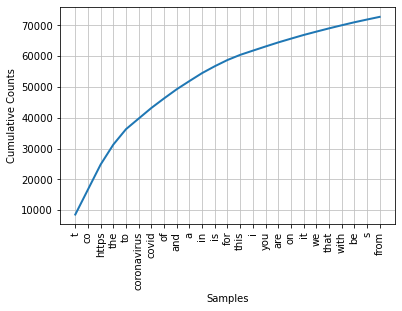

In [13]:
frequency_distribution = FreqDist(words_list)
# Checking the frequency of words coming
frequency_distribution.plot(25, cumulative=True)

### Observation: Shows 25 words to occur 760000 which can be removed easily.

In [14]:
# happen only once
len(frequency_distribution.hapaxes())

22889

### Observation: Shows 153535 words occur only once which can be removed.

In [15]:
# getting bigrams from the bag of words
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_words(words_list)
bigram_list=finder.nbest(bigram_measures.pmi, 200)
# print(bigram_list)

In [16]:
# appending bigrams to unigrams dictionary 
merged_dict = dict()
for i in initial_unigram_dict.keys():
    # Adding bigram_list to the list of unigram listing
    merged_dict[i] = list(bigram_list + initial_unigram_dict[i])

# print(merged_dict[i])

### 8. MWE Tokenizer 

In [17]:
# new empty dictionay 
mwe_tokenizer_dict = dict()

for i in merged_dict.keys():
    mwe_tokenizer = MWETokenizer(merged_dict[i])
    mwe_tokenizer_dict[i] = mwe_tokenizer.tokenize(initial_unigram_dict[i])

# print(len(mwe_tokenizer_dict[i]))

##### Observation:

1. The raw_text has been split into a list of tokens that contains both unigrams and multi-word expressions. However, the list contains a lot of functional words, such as "to", "in", "the", "is" and so on. 
2. These functional words usually do not contribute much to the semantics of the text, except for increase the dimensionality of the data in text analysis. 
3. Therefore, we can choose to remove those words, which is your next task.

### 9. Tokens Removal

#### Removing rare token and context dependent tokens if there occurences is with threshold less than 5 days or more than 60 days

In [18]:
tokens = []
for x in mwe_tokenizer_dict.keys():
    for y in mwe_tokenizer_dict[x]:
        if len(y) < 3:
            tokens.append(y)

token_removal_dict = remove_words_from_list(tokens, mwe_tokenizer_dict)

In [19]:
# creating two dictionaries 
bigram_dict = {}
unigram_dict = {}

for i in token_removal_dict.keys():
    unigram_dict[i] = [x for x in token_removal_dict[i] if "_" not in x]
    bigram_dict[i] = [x for x in token_removal_dict[i] if "_" in x]
    
#print(unigram_dict)


In [20]:
threshold_list = []

unique_words_list = list(chain.from_iterable([set(value) for value in  unigram_dict.values()]))
fd = FreqDist(unique_words_list)
tuple_threshold = fd.most_common()

for j in range(len(tuple_threshold)):
    if tuple_threshold[j][1] < 5 or tuple_threshold[j][1] > 60:
        threshold_list.append(tuple_threshold[j][0])
    
    
print(len(threshold_list))

28300


In [21]:
# Removing threshold words for the dictionary
threshold_final = remove_words_from_list(threshold_list, unigram_dict)
# print(threshold_final)

In [22]:
final_stem_dict = stem_compressing(threshold_final)
#print(final_stem_dict)

In [23]:
# joining bigram and unigram(after removing stop words)
result = {}

for i in final_stem_dict.keys():
    result[i] = [x for x in final_stem_dict[i]]
    result[i] = result[i] + bigram_dict[i]

# print(result)

In [24]:
# vocab list is created using chaining of each value in the result dict
vocab_final_list = list(chain.from_iterable(result.values()))

# Creating a set of unique vocab list 
vocab_set = set(vocab_final_list)
# print(vocab_final_set)
sorted_vocab_set = sorted(list(vocab_set))
print('Size of sorted_vocab_set : ',len(sorted_vocab_set))

Size of sorted_vocab_set :  1836


In [43]:
# Creating a vocab list from the sorted set of vocabs i.e. these words exist 
with open('31153054_vocab.txt','w', encoding='utf-8') as f:
    for index in range(len(c)):
        f.write(c[index]+":"+str(index)+"\n")
        

### 10. Count Vectorization

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word") 

data_features = vectorizer.fit_transform([' '.join(value) for value in result.values()])
print (data_features.shape)


(81, 11228)


In [44]:
with open('31153054_countVec.txt','w',encoding='utf-8') as f:
    dict_index = 0
    for x in result.keys():
        start = x
        for word, count in zip(sorted_vocab_set, data_features.toarray()[dict_index]):
            if count > 0:
                start = start + "," + str(sorted_vocab_set.index(word)) + ":" + str(count)
        dict_index = dict_index + 1
        f.write(start + "\n")

### Summary

1. The raw_text has been split into a list of tokens that contains both unigrams and multi-word expressions. However, the list contains a lot of functional words, such as "to", "in", "the", "is" and so on. 
2. These functional words usually do not contribute much to the semantics of the text, except for increase the dimensionality of the data in text analysis. 
3. Also, note that our goal is to build a classification model of predicting fungal disease. Thus, we are more interested in the meaning of the diagnostic report than the syntax. Therefore, we can choose to remove those words, which is your next task.

## 9. References
1. Blank B. (2011, January 19). *Regex non-consecutive chars* [Response to]. Retrieved from http://stackoverflow.com/a/4739636
2. McKinney W. (2012, April 29). *Converting a Pandas GroupBy object to DataFrame* [Response to]. Retrieved from http://stackoverflow.com/a/10374456
3. NLTK Project. (2017). *NLTK 3.0 documentation: `nltk.tokenize.regexp` module*. Retrieved from http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.regexp.RegexpTokenizer